In [1]:
import json
import torch
import imageio

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
IMG_SIZE = (360, 640)

In [3]:
annos = json.load(open("annotations.json"))
removed = json.load(open("removed.json"))
frames = imageio.get_reader("data/doom_video.mp4", format = "ffmpeg")

In [4]:
annos[0]

{'label': '7.1',
 'image_id': 34,
 'bbox': [0.546875, 0.42777777777777776, 0.575, 0.49166666666666664]}

In [5]:
frames.get_data(0).shape

(360, 640, 3)

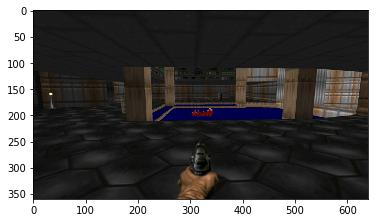

In [6]:
plt.imshow(frames.get_data(34))

In [7]:
[item for item in annos if item['image_id'] == 34]

[{'label': '7.1',
  'image_id': 34,
  'bbox': [0.546875, 0.42777777777777776, 0.575, 0.49166666666666664]},
 {'label': '7.1',
  'image_id': 34,
  'bbox': [0.25, 0.4388888888888889, 0.2921875, 0.5611111111111111]}]

In [20]:
def bbox_to_mpl_rect(coords):
    #Coords consists of (x1, y1, x2, y2) where x and y are treated in the Cartesian sense
    #(x1, y1) is the top left corner, (x2, y2) is the bottom right corner
    #Transforms inputs into ((bottom left corner), width, height)
    return (coords[0], coords[3]), coords[2] - coords[0], coords[1] - coords[3]

def scale_bbox(raw_bbox, inverse = False):
    if not inverse:
        return tuple([x * y for x, y in zip(raw_bbox, IMG_SIZE[::-1] * 2)])
    else:
        return tuple([x / y for x, y in zip(raw_bbox, IMG_SIZE[::-1] * 2)])

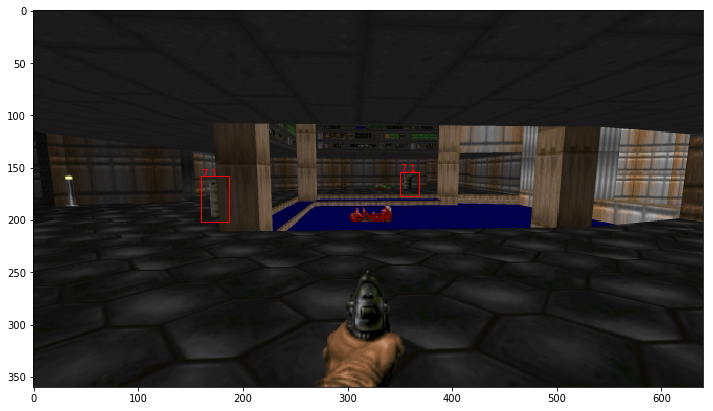

In [9]:
fig, ax = plt.subplots(figsize = (12, 18))
ax.imshow(frames.get_data(34))
for bbox in [item for item in annos if item['image_id'] == 34]:
    scaled = tuple([x * y for x, y in zip(bbox["bbox"], IMG_SIZE[::-1] * 2)])
    ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(scaled), fill = False, color = "red"))
    ax.text(*scaled[:2], bbox["label"], color = "red")

In [10]:
def get_bbox_area(bbox):
    return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

def get_bbox_intersection(a, b):
    #Assumes that a and b are PROPERLY FORMATTED bounding boxes
    #i.e. x1, y1 is the top left corner and x2, y2 is the bottom right corner
    x1 = max(a[0], b[0])
    x2 = min(a[2], b[2])
    
    y1 = max(a[1], b[1])
    y2 = min(a[3], b[3])
    
    if (x2 - x1 < 0) or (y2 - y1 < 0):
        return None
    else:
        return x1, y1, x2, y2

def iou(bbox1, bbox2):
    inter = get_bbox_intersection(bbox1, bbox2)
    if not inter:
        return 0
    else:
        inter_area = get_bbox_area(inter)
        return inter_area / (get_bbox_area(bbox1) + get_bbox_area(bbox2) - inter_area)

In [11]:
get_bbox_area(annos[0]['bbox']), get_bbox_area(annos[1]['bbox'])

(0.001796874999999997, 0.005156249999999999)

In [12]:
import pandas as pd
pd.Series([get_bbox_area(item["bbox"]) for item in annos]).describe()

count    485.000000
mean       0.018012
std        0.043210
min        0.000430
25%        0.002917
50%        0.005786
75%        0.015087
max        0.449019
dtype: float64

In [13]:
get_bbox_intersection(annos[0]["bbox"], annos[1]["bbox"])

In [14]:
import numpy as np

In [15]:
def normalize_bbox(bbox):
    #Takes in bounding box coordinates and ensures that the x1, y1 coordinates correspond to the top-left corner
    if bbox[0] > bbox[2]:
        bbox[0], bbox[2] = bbox[2], bbox[0]
    if bbox[1] > bbox[3]:
        bbox[1], bbox[3] = bbox[3], bbox[1]
    return bbox

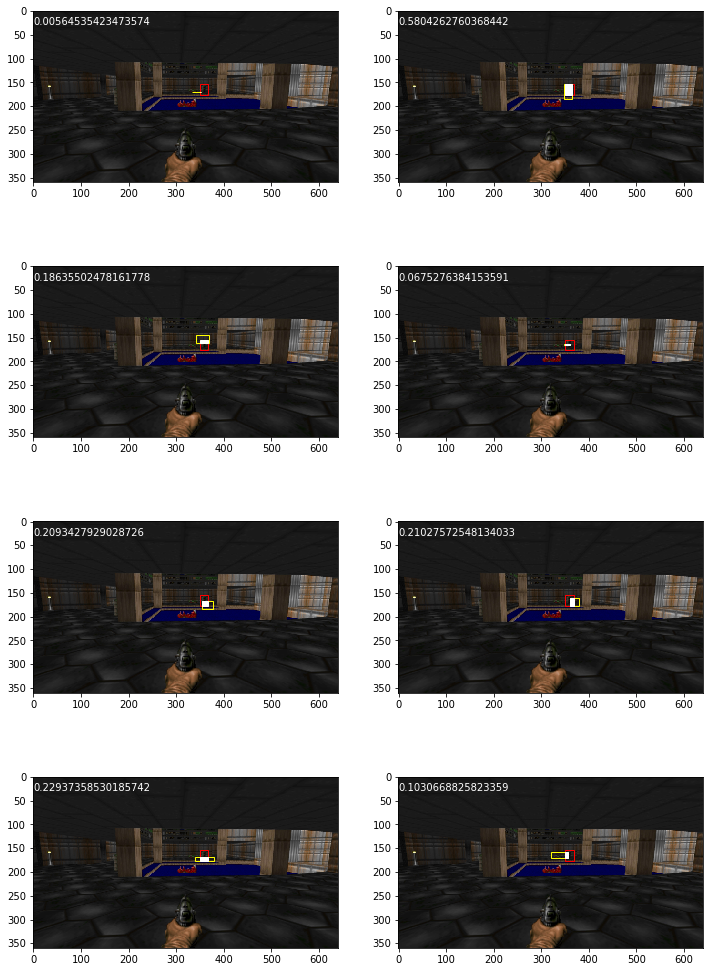

In [16]:
first_box = [0.546875, 0.42777777777777776, 0.575, 0.49166666666666664]
fig, axs = plt.subplots(4, 2, figsize = (12, 18))
for ax in axs.flat:
    test_box = np.array(first_box)
    test_box += np.random.uniform(-.05, .05, size = (4,))
    normalize_bbox(test_box)
    ax.imshow(frames.get_data(34))
    ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(scale_bbox(first_box)), fill = False, color = "red"))
    ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(scale_bbox(test_box)), fill = False, color = "yellow"))
    inter = get_bbox_intersection(first_box, test_box)
    if inter:
        ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(scale_bbox(inter)), fill = True, color = "white"))
    ax.text(0, 30, str(iou(first_box, test_box)), color = "white")


In [17]:
def partition_into_bboxes(width, height, k = 2):
    assert width % k == 0 and height % k == 0, "k doesn't divide into even chunks"
    wf, hf = width // k, height // k
    for i in range(k):
        for j in range(k):
            yield (wf * i, hf * j, wf * (i + 1), hf * (j + 1))

list(partition_into_bboxes(*IMG_SIZE))

[(0, 0, 180, 320),
 (0, 320, 180, 640),
 (180, 0, 360, 320),
 (180, 320, 360, 640)]

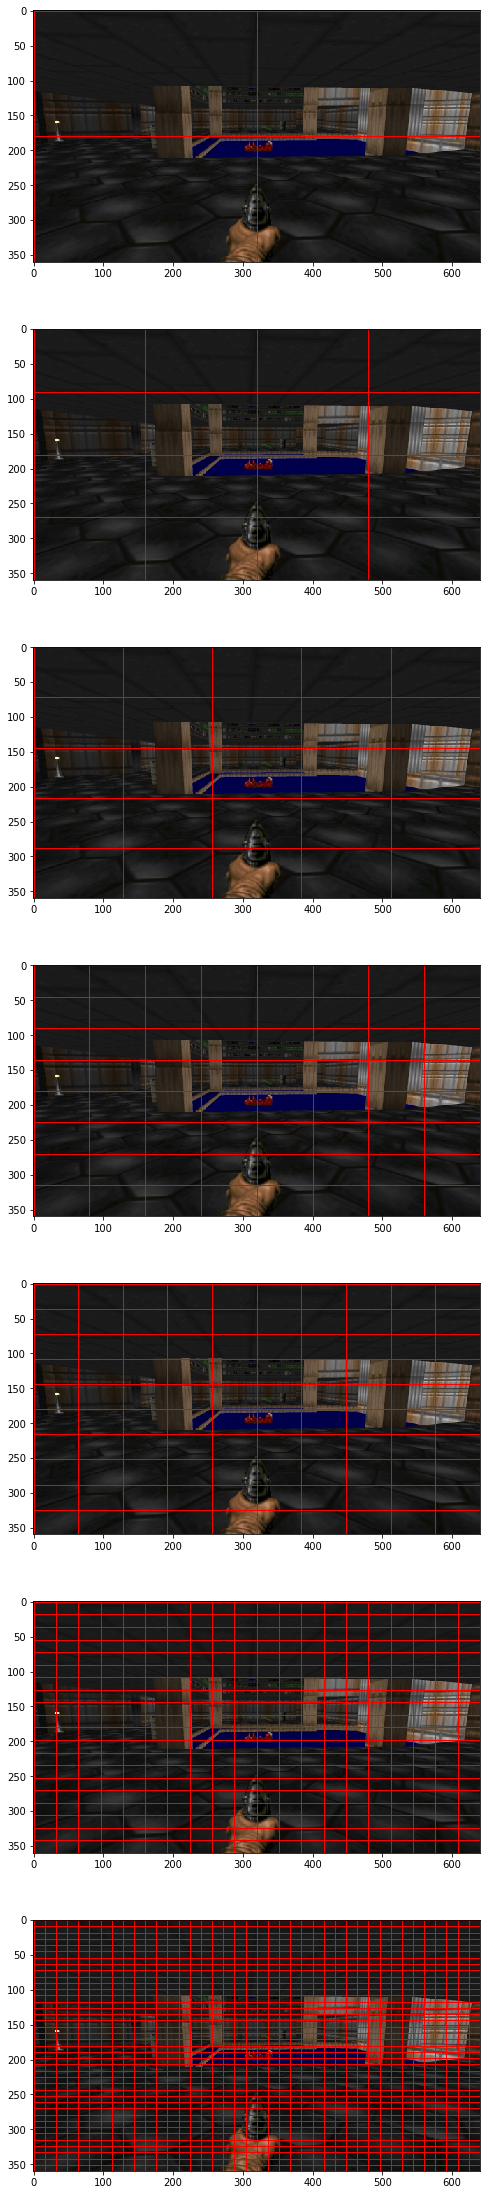

In [18]:
fig, axs = plt.subplots(7, 1, figsize = (8, 40))
for k, ax in zip([2, 4, 5, 8, 10, 20, 40], axs.flat):
    ax.imshow(frames.get_data(34))
    for bbox in partition_into_bboxes(*IMG_SIZE[::-1], k = k):
        ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(bbox), fill = False, color = "red"))

In [28]:
#20x grid:  2x2x5
annos[:100]

[{'label': '7.1',
  'image_id': 34,
  'bbox': [0.546875, 0.42777777777777776, 0.575, 0.49166666666666664]},
 {'label': '7.1',
  'image_id': 34,
  'bbox': [0.25, 0.4388888888888889, 0.2921875, 0.5611111111111111]},
 {'label': '7.4',
  'image_id': 43,
  'bbox': [0.60625, 0.3333333333333333, 0.7640625, 0.8472222222222222]},
 {'label': '7.1',
  'image_id': 43,
  'bbox': [0.378125, 0.4527777777777778, 0.40625, 0.5333333333333333]},
 {'label': '3.1',
  'image_id': 43,
  'bbox': [0.853125, 0.525, 0.9, 0.6305555555555555]},
 {'label': '7.4',
  'image_id': 46,
  'bbox': [0.16875, 0.35, 0.3, 0.7611111111111111]},
 {'label': '3.1',
  'image_id': 46,
  'bbox': [0.575, 0.5055555555555555, 0.609375, 0.5777777777777777]},
 {'label': '7.1',
  'image_id': 46,
  'bbox': [0.1015625, 0.4638888888888889, 0.14375, 0.5472222222222223]},
 {'label': '3.1',
  'image_id': 53,
  'bbox': [0.6625, 0.4861111111111111, 0.69375, 0.5638888888888889]},
 {'label': '7.1',
  'image_id': 53,
  'bbox': [0.209375, 0.438888888

In [31]:
img_id = 301
max_ious = []
max_bboxs = []
bboxs = []
for anno in [item for item in annos if item['image_id'] == img_id]:
    bboxs.append(scale_bbox(anno['bbox']))
    max_iou = 0
    max_bbox = None
    for bbox in partition_into_bboxes(*IMG_SIZE[::-1], k = 2):
        overlap = iou(scale_bbox(anno['bbox']), bbox)
        if overlap > max_iou:
            max_iou = overlap
            max_bbox = bbox
    for bbox in partition_into_bboxes(*IMG_SIZE[::-1], k = 10):
        overlap = iou(scale_bbox(anno['bbox']), bbox)
        if overlap > max_iou:
            max_iou = overlap
            max_bbox = bbox
    for bbox in partition_into_bboxes(*IMG_SIZE[::-1], k = 20):
        overlap = iou(scale_bbox(anno['bbox']), bbox)
        if overlap > max_iou:
            max_iou = overlap
            max_bbox = bbox
    
    max_ious.append(max_iou)
    max_bboxs.append(max_bbox)
list(zip(bboxs, max_ious, max_bboxs))

[((300.0, 103.0, 338.0, 142.0), 0.2189311010946555, (256, 108, 320, 144)),
 ((256.0, 100.0, 290.0, 124.0), 0.5818181818181818, (256, 108, 288, 126)),
 ((294.0, 46.0, 554.0, 100.0), 0.2141549725442343, (320, 0, 640, 180)),
 ((283.0, 110.00000000000001, 312.0, 140.0),
  0.37760416666666646,
  (256, 108, 320, 144))]

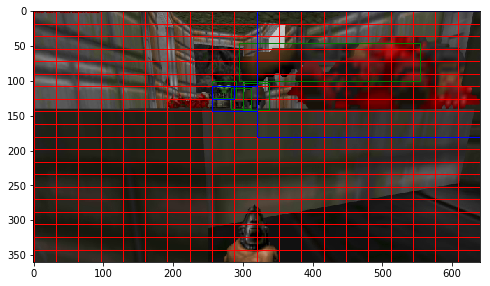

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.imshow(frames.get_data(img_id))
for bbox in partition_into_bboxes(*IMG_SIZE[::-1], k = 20):
    ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(bbox), fill = False, color = "red"))
for bbox in bboxs:
    ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(bbox), fill = False, color = "green"))
for bbox in max_bboxs:
    ax.add_patch(plt.Rectangle(*bbox_to_mpl_rect(bbox), fill = False, color = "blue"))
